## 1. Load dataset

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import cvxpy as cp
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.decomposition import KernelPCA


In [121]:
# Load UCI Digits dataset
digits = datasets.load_digits()
X, y = digits.data, digits.target
X = X[:100]

print(X.shape)


(100, 64)


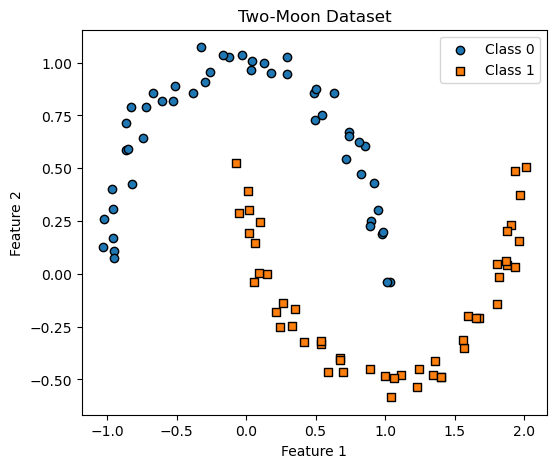

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Generate two-moon dataset
X, y = make_moons(n_samples=100, noise=0.05)

# Visualize the dataset
plt.figure(figsize=(6, 5))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], label="Class 0", marker='o', edgecolor='k')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label="Class 1", marker='s', edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Two-Moon Dataset")
plt.legend()
plt.show()

## 2. Algorithm

### 2.1 Single View Graph Learning

In [123]:
import numpy as np
from scipy.sparse.linalg import eigsh
from scipy.optimize import nnls
from sklearn import datasets
from tqdm import tqdm 

def estimate_sigma(X):
    pairwise_dists = np.linalg.norm(X[:, np.newaxis] - X, axis=2)  # Compute pairwise L2 distances
    sigma = np.median(pairwise_dists)  # Use the median distance as sigma
    return sigma

def similarity_matrix(X):
    sigma = 1.0  # 控制衰减速度
    sim_matrix = rbf_kernel(X, gamma=1/(2*sigma**2))
    
    return sim_matrix

def compute_laplacian(S):
    S_sym = (S.T + S) / 2  # Compute symmetric part
    D = np.diag(S_sym.sum(axis=0))  # Compute diagonal matrix D
    L = D - S_sym  # Compute Laplacian matrix
    return L

def update_Q(L, c):
    eigenvalues, eigenvectors = np.linalg.eigh(L)
    Q = eigenvectors[:, :c]
    return Q

# def update_S(Q, beta):
#     n, c = Q.shape
#     G = np.linalg.norm(Q[:, None, :] - Q[None, :, :], axis=2, ord=2) ** 2  # Compute gij
#     S = np.zeros((n, n))
    
#     for j in range(n):
#         g_j = G[:, j]  # Extract gj vector
#         eta = 100
#         s_j = np.maximum(-g_j / (2 * beta) + eta, 0)  # Apply the optimal solution formula
#         S[:, j] = s_j / np.sum(s_j)  # Normalize to satisfy the constraint
    
#     return S

# def simplex_projection(v):

#     n_features = v.shape[0]
#     u = np.sort(v)[::-1]  
#     cumsum_u = np.cumsum(u)
#     indices = np.arange(1, n_features+1)
#     cond = u - (cumsum_u - 1.0) / indices > 0
#     rho = indices[cond][-1] if np.any(cond) else 0
#     theta = (cumsum_u[cond][-1] - 1.0) / rho if rho > 0 else 0
#     w = np.maximum(v - theta, 0)
#     return w

# def update_S(Q, beta):
#     n = Q.shape[0]
#     S = np.zeros((n, n))
    
#     dist_sq = np.sum((Q[:, np.newaxis, :] - Q[np.newaxis, :, :]) ** 2, axis=-1)
    
#     for j in range(n):
#         gj = dist_sq[:, j]
#         u_j = -gj / (2 * beta)
#         s_j = simplex_projection(u_j)
#         s_j = np.clip(s_j, 0, None)
#         s_j /= s_j.sum()
#         S[:, j] = s_j
    
#     return S

def update_S(Q, beta):
    """
    Update the similarity matrix S given Q and beta.
    
    Parameters:
    Q : numpy array of shape (n, c)
        The input matrix where each row is a data point.
    beta : float
        Regularization parameter controlling the Frobenius norm penalty.
        
    Returns:
    S : numpy array of shape (n, n)
        The updated similarity matrix where each column sums to 1 and is non-negative.
    """
    n, c = Q.shape
    S = np.zeros((n, n))
    
    for j in range(n):
        # Compute squared distances from Q[j] to all Q[i]
        q_j = Q[j]
        d = np.sum((Q - q_j) ** 2, axis=1)
        
        # Create a list of (distance, original index) and sort by distance
        sorted_pairs = sorted(zip(d, range(n)), key=lambda x: x[0])
        sorted_d = [pair[0] for pair in sorted_pairs]
        original_indices = [pair[1] for pair in sorted_pairs]
        
        # Find the optimal m and lambda
        best_m = 0
        best_lambda = 0.0
        sum_d = 0.0
        
        for m in range(1, n + 1):
            sum_d += sorted_d[m - 1]
            lambda_candidate = (sum_d + 2 * beta) / m
            
            # Check the conditions for valid lambda
            if m < n:
                next_d = sorted_d[m]
            else:
                next_d = float('inf')
            
            if lambda_candidate > sorted_d[m - 1]:
                if (m == n) or (lambda_candidate <= next_d):
                    best_m = m
                    best_lambda = lambda_candidate
        
        # Compute the values for the optimal m
        s_j = np.zeros(n)
        if best_m > 0:
            for i in range(best_m):
                original_idx = original_indices[i]
                s_j[original_idx] = (best_lambda - sorted_d[i]) / (2 * beta)
        
        S[:, j] = s_j
    
    return S

In [124]:
class_number = 2
beta = 1

# X = StandardScaler().fit_transform(X) # don't do this
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_kpca = kpca.fit_transform(X)


# init
similarity_matrix = similarity_matrix(X_kpca)
S = update_S(X_kpca, beta)
L = compute_laplacian(S)
Q = update_Q(L, class_number)

for i in tqdm(range(100)):
    S = update_S(Q, beta)
    L = compute_laplacian(S)
    Q = update_Q(L, class_number)

    L_rank = np.linalg.matrix_rank(L)
    # print(L_rank, beta)
    if L_rank == X.shape[0] - class_number:
        print(f"end at {i}th iteration, L's rank is {L_rank}")
        break
    elif L_rank > X.shape[0] - class_number:
        beta *= 0.9 
    else:
        beta *= 1.1
    
    
print(f"final L's rank is {L_rank}, final beta is {beta}")

  8%|▊         | 8/100 [00:00<00:01, 58.27it/s]

end at 8th iteration, L's rank is 98
final L's rank is 98, final beta is 0.43046721000000016


# 3. Visualization

In [125]:
print(S)

[[0.01886792 0.         0.01886792 ... 0.         0.01886792 0.        ]
 [0.         0.0212766  0.         ... 0.0212766  0.         0.0212766 ]
 [0.01886792 0.         0.01886792 ... 0.         0.01886792 0.        ]
 ...
 [0.         0.0212766  0.         ... 0.0212766  0.         0.0212766 ]
 [0.01886792 0.         0.01886792 ... 0.         0.01886792 0.        ]
 [0.         0.0212766  0.         ... 0.0212766  0.         0.0212766 ]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


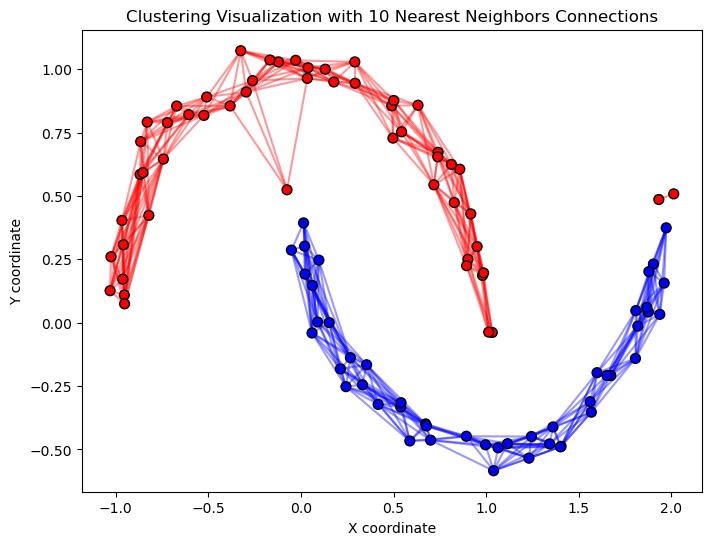

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from matplotlib.colors import ListedColormap

def plot_clusters(X, S, n_nearest = 5):
    model = SpectralClustering(n_clusters=2, affinity='precomputed',
                               assign_labels='discretize', random_state=42)
    clusters = model.fit_predict(S)
    
    n = X.shape[0]
    D = np.linalg.norm(X[:, np.newaxis, :] - X, axis=2)
    S_new = np.zeros((n, n), dtype=int)
    for i in range(n):
        nearest_neighbors = np.argsort(D[i])[1:n_nearest+1]
        S_new[i, nearest_neighbors] = 1 
    
    # plot 
    colors = ['blue', 'red']
    cmap = ListedColormap(colors)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap=cmap, 
                edgecolor='k', s=50, zorder=2)
    
    for i in range(n):
        for j in range(i + 1, n):
            if (S_new[i, j] or S_new[j, i]) and clusters[i] == clusters[j]:
                plt.plot([X[i, 0], X[j, 0]], [X[i, 1], X[j, 1]],
                         color=colors[clusters[i]], alpha=0.4, zorder=1)
    
    plt.title(f'Clustering Visualization with {n_nearest} Nearest Neighbors Connections')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.show()

plot_clusters(X, S, 10)